In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections as counter
import gc
import itertools
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix, f1_score
)
from imblearn.over_sampling import RandomOverSampler
import accelerate
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop, Compose, Normalize, RandomRotation, RandomResizedCrop, 
    RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor
)

C:\Users\GUNATEJA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [4]:
from pathlib import Path
import pandas as pd

file_names = []
labels = []

# Use raw string for the path to handle backslashes properly
dataset_path = r'\Projects\hackathon\Dataset'

for file in sorted(Path(dataset_path).glob('*/*/*.*')):
    try:
        # Use Path.parts to reliably extract the label
        label = file.parts[-2]  # Extract the second-to-last folder name
        file_names.append(str(file))
        labels.append(label)
    except IndexError:
        print(f"Skipping file: {file} (does not match expected directory structure)")

print(f"Total files: {len(file_names)}")
print(f"Total labels: {len(labels)}")

# Create DataFrame and save as CSV
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(f"DataFrame shape: {df.shape}")
print(df.head())
df.to_csv("image_data.csv", index=False)
print("DataFrame saved as 'image_data.csv'")


Total files: 190335
Total labels: 190335
DataFrame shape: (190335, 2)
                                               image label
0   \Projects\hackathon\Dataset\Test\Fake\fake_0.jpg  Fake
1   \Projects\hackathon\Dataset\Test\Fake\fake_1.jpg  Fake
2  \Projects\hackathon\Dataset\Test\Fake\fake_10.jpg  Fake
3  \Projects\hackathon\Dataset\Test\Fake\fake_100...  Fake
4  \Projects\hackathon\Dataset\Test\Fake\fake_100...  Fake
DataFrame saved as 'image_data.csv'


In [5]:
df.head()

,image,label
0,\Projects\hackathon\Dataset\Test\Fake\fake_0.jpg,Fake
1,\Projects\hackathon\Dataset\Test\Fake\fake_1.jpg,Fake
2,\Projects\hackathon\Dataset\Test\Fake\fake_10.jpg,Fake
3,\Projects\hackathon\Dataset\Test\Fake\fake_100...,Fake
4,\Projects\hackathon\Dataset\Test\Fake\fake_100...,Fake


In [6]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [7]:
from imblearn.over_sampling import RandomOverSampler
import gc
if 'label' not in df.columns:
    raise KeyError("The column 'label' is missing in the DataFrame.")
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_over = ros.fit_resample(df, y)
df['label'] = y_over
gc.collect()
print(df.shape)




(190402, 2)


In [8]:
df.head()

,image,label
0,\Projects\hackathon\Dataset\Test\Fake\fake_0.jpg,Fake
1,\Projects\hackathon\Dataset\Test\Fake\fake_1.jpg,Fake
2,\Projects\hackathon\Dataset\Test\Fake\fake_10.jpg,Fake
3,\Projects\hackathon\Dataset\Test\Fake\fake_100...,Fake
4,\Projects\hackathon\Dataset\Test\Fake\fake_100...,Fake


In [10]:
# Install the datasets package
%pip install datasets

from datasets import Dataset, Image
dataset = Dataset.from_pandas(df).cast_column("image", Image())

   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   - -------------------------------------- 1.0/25.3 MB 7.1 MB/s eta 0:00:04
   ---- ----------------------------------- 2.6/25.3 MB 6.9 MB/s eta 0:00:04
   ------- -------------------------------- 5.0/25.3 MB 7.9 MB/s eta 0:00:03
   ------------ --------------------------- 7.9/25.3 MB 9.4 MB/s eta 0:00:02
   ------------------ --------------------- 11.5/25.3 MB 11.1 MB/s eta 0:00:02
   -------------------------- ------------- 16.5/25.3 MB 13.3 MB/s eta 0:00:01
   ---------------------------------- ----- 21.8/25.3 MB 14.9 MB/s eta 0:00:01
   ---------------------------------------- 25.3/25.3 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
Note: you may need to restart the kernel to use updated packages.


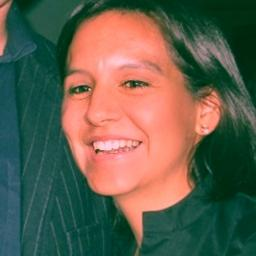

In [11]:
dataset[22]["image"]

In [12]:
labels_list=['Real','Fake']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i  
    id2label[i] = label 

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [13]:
from datasets import Dataset, ClassLabel
label_list = ['Real', 'Fake']
class_labels = ClassLabel(num_classes=len(label_list), names=label_list)
def map_label2id(example):
    example['label'] = class_labels.str2int(example['label'])
    return example
dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', class_labels)
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']


Casting the dataset: 100%|██████████| 190402/190402 [00:00<00:00, 5810605.94 examples/s]


In [18]:
from torchvision.transforms import Compose, Normalize, Resize, RandomRotation, RandomAdjustSharpness, ToTensor
from transformers import ViTImageProcessor
from PIL import Image

# Define the pre-trained model string
model_str = 'google/vit-base-patch16-224-in21k'

# Create a processor for the ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
_train_transforms = Compose(
    [
        Resize((size, size)),       # Resize images to the ViT model's input size
        RandomRotation(90),         # Apply random rotation
        RandomAdjustSharpness(2),   # Adjust sharpness randomly
        ToTensor(),                 # Convert images to tensors
        normalize                   # Normalize images using mean and std
    ]
)

# Define a set of transformations for validation data
_val_transforms = Compose(
    [
        Resize((size, size)),       # Resize images to the ViT model's input size
        ToTensor(),                 # Convert images to tensors
        normalize                   # Normalize images using mean and std
    ]
)

# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples


Size:  224


C:\Users\GUNATEJA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GUNATEJA\.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [19]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)


In [20]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example["label"] for example in examples])

    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}


In [21]:
from transformers import ViTForImageClassification

# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [22]:
!pip install evaluate
import evaluate

# Load the accuracy metric from a module named 'evaluate'
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }


In [26]:
# Install the tf-keras package
%pip install tf-keras

from transformers import TrainingArguments
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "deepfake_vs_real_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 2

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,

    # Specify the directory where training logs will be stored.
    logging_dir='./logs',

    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",

    # Set the learning rate for the optimizer.
    learning_rate=1e-6,

    # Define the batch size for training on each device.
    per_device_train_batch_size=32,

    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,

    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,

    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,

    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,

    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

    # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy='epoch',

    # Load the best model at the end of training.
    load_best_model_at_end=True,

    # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

    # Specify that training progress should not be reported.
    report_to=None,
)

Note: you may need to restart the kernel to use updated packages.


In [27]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    eval_strategy="epoch",  # Changed from evaluation_strategy
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [28]:
from transformers import Trainer

# Create a Trainer instance for fine-tuning a language model.
# - `model`: The pre-trained language model to be fine-tuned.
# - `args`: Configuration settings and hyperparameters for training.
# - `train_dataset`: The dataset used for training the model.
# - `eval_dataset`: The dataset used for evaluating the model during training.
# - `data_collator`: A function that defines how data batches are collated and processed.
# - `compute_metrics`: A function for computing custom evaluation metrics.
# - `tokenizer`: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    processing_class=processor
)

In [31]:
trainer.save_model()